In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [17]:
def compute_disparity(left_image, right_image, window_size=5, max_disparity=32):
    height, width = left_image.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)
    half_window = window_size // 2
    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            left_block = left_image[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]
            min_sad = float('inf')
            best_disparity = 0
            for d in range(0, max_disparity):
                if x - d - half_window >= 0:
                    right_block = right_image[y - half_window:y + half_window + 1, x - d - half_window:x - d + half_window + 1]
                    sad = np.sum(np.abs(left_block - right_block))
                    if sad < min_sad:
                        min_sad = sad
                        best_disparity = d
            disparity_map[y, x] = best_disparity

    disparity_map = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)
    return disparity_map.astype(np.uint8)


In [18]:
def compute_depth_map(disparity_map, focal_length, baseline):
    disparity_map = disparity_map.astype(np.float32)
    
    # Avoid division by zero by replacing disparity values of zero with a small number
    disparity_map[disparity_map == 0] = 1e-5
    
    # Compute depth map using the formula: Z = (f * B) / d
    depth_map = (focal_length * baseline) / disparity_map
    
    # Normalize depth map for better visualization (optional)
    depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    
    return depth_map.astype(np.uint8)

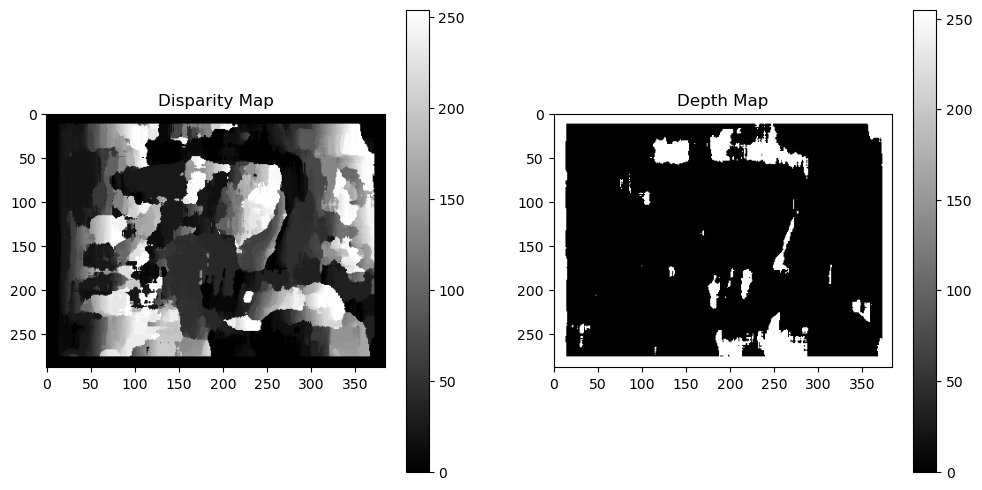

In [19]:
left_image = cv2.imread('sterio_data/test1.jpg', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('sterio_data/test2.jpg', cv2.IMREAD_GRAYSCALE)

focal_length = 20
baseline = 10
disparity = compute_disparity(left_image, right_image, window_size=25, max_disparity=64)
depth_map = compute_depth_map(disparity, focal_length, baseline)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(disparity, cmap='grey')
plt.title("Disparity Map")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap='grey')
plt.title("Depth Map")
plt.colorbar()

plt.show()

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

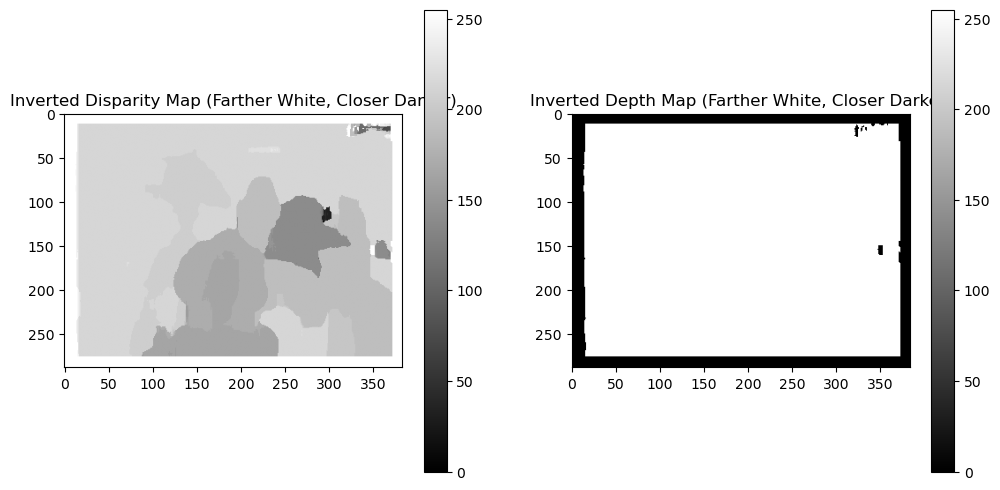

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_disparity(left_image, right_image, window_size=5, max_disparity=64):
    # Compute Sobel gradients
    grad_left_x = cv2.Sobel(left_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_left_y = cv2.Sobel(left_image, cv2.CV_64F, 0, 1, ksize=3)
    grad_right_x = cv2.Sobel(right_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_right_y = cv2.Sobel(right_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute magnitude of gradients
    grad_left = np.sqrt(grad_left_x**2 + grad_left_y**2)
    grad_right = np.sqrt(grad_right_x**2 + grad_right_y**2)
    
    height, width = left_image.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)
    half_window = window_size // 2
    
    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            left_block = grad_left[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]
            min_sad = float('inf')
            best_disparity = 0
            
            for d in range(0, max_disparity):
                if x - d - half_window >= 0:
                    right_block = grad_right[y - half_window:y + half_window + 1, x - d - half_window:x - d + half_window + 1]
                    sad = np.sum(np.abs(left_block - right_block))
                    if sad < min_sad:
                        min_sad = sad
                        best_disparity = d
            disparity_map[y, x] = best_disparity

    disparity_map = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)
    return disparity_map.astype(np.uint8)

def compute_depth_map(disparity_map, focal_length, baseline):
    disparity_map = disparity_map.astype(np.float32)
    
    # Avoid division by zero by replacing disparity values of zero with a small number
    disparity_map[disparity_map == 0] = 1e-5
    
    # Compute depth map using the formula: Z = (f * B) / d
    depth_map = (focal_length * baseline) / disparity_map
    
    # Normalize depth map for better visualization (optional)
    depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    
    return depth_map.astype(np.uint8)

# Load stereo images
left_image = cv2.imread('sterio_data/test1.jpg', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('sterio_data/test2.jpg', cv2.IMREAD_GRAYSCALE)

focal_length = 20
baseline = 10

# Compute disparity map and depth map
disparity = compute_disparity(left_image, right_image, window_size=25, max_disparity=32)
depth_map = compute_depth_map(disparity, focal_length, baseline)

# Invert disparity and depth maps such that farther objects are white, closer are darker
# Invert the disparity map
inverted_disparity = cv2.bitwise_not(disparity)

# Invert the depth map
inverted_depth_map = cv2.bitwise_not(depth_map)

# Display results
plt.figure(figsize=(12, 6))

# Display Inverted Disparity Map (Farther objects are white, closer objects are darker)
plt.subplot(1, 2, 1)
plt.imshow(inverted_disparity, cmap='gray')
plt.title("Inverted Disparity Map (Farther White, Closer Darker)")
plt.colorbar()

# Display Inverted Depth Map (Farther objects are white, closer objects are darker)
plt.subplot(1, 2, 2)
plt.imshow(inverted_depth_map, cmap='gray')
plt.title("Inverted Depth Map (Farther White, Closer Darker)")
plt.colorbar()

plt.show()


In [22]:
# Function to compute the depth map from the disparity map
def compute_depth_map(disparity_map, focal_length, baseline):
    disparity_map = disparity_map.astype(np.float32)
    disparity_map[disparity_map == 0] = 1e-5  # Avoid division by zero
    
    # Depth map Z = (f * B) / d
    depth_map = (focal_length * baseline) / disparity_map
    return depth_map

# Function to create a 3D point cloud from the disparity map
def create_point_cloud(disparity_map, focal_length, baseline):
    # Get depth map from disparity map
    depth_map = compute_depth_map(disparity_map, focal_length, baseline)

    height, width = disparity_map.shape
    points = []

    # Iterate through the pixels and calculate the corresponding 3D points
    for y in range(height):
        for x in range(width):
            Z = depth_map[y, x]
            if Z != 0:
                X = (x - width / 2) * Z / focal_length  # Convert to real-world coordinates (X)
                Y = (y - height / 2) * Z / focal_length  # Convert to real-world coordinates (Y)
                points.append([X, Y, Z])

    points = np.array(points)
    return points

# Function to visualize the 3D point cloud using Open3D
def visualize_point_cloud(points):
    # Create Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])

# Example usage
# Load disparity map (you should already have a disparity map from your matching algorithm)
#disparity_map = cv2.imread('disparity_map.png', cv2.IMREAD_GRAYSCALE)  # Make sure this is the disparity map
disparity_map=result
focal_length = 20  # Focal length in pixels
baseline = 3  # Baseline in meters

# Create point cloud from the disparity map
points = create_point_cloud(disparity_map, focal_length, baseline)

# Visualize the 3D point cloud
visualize_point_cloud(points)


[Open3D WARNING] GLFW Error: Wayland: The platform does not support setting the window position
[Open3D WARNING] Failed to initialize GLEW.
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.



(python:51146): Gtk-WARNING **: 22:46:19.524: gtk_disable_setlocale() must be called before gtk_init()


In [32]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
imgLeft = cv2.imread('sterio_data/test1.jpg')  
imgRight = cv2.imread('sterio_data/test2.jpg')  

grayLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY)

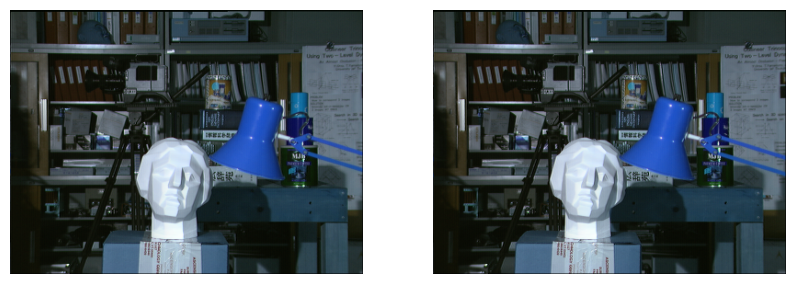

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(imgLeft, 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(imgRight, 'gray')
plt.axis('off')
plt.show()

In [38]:
def ShowDisparity(bSize=5):
    min_disp = 0
    num_disp = 16 * 5  
    block_size = bSize

    stereo = cv2.StereoSGBM_create(minDisparity=min_disp,
                                   numDisparities=num_disp,
                                   blockSize=block_size,
                                   P1=8 * 3 * block_size**2,
                                   P2=32 * 3 * block_size**2,
                                   disp12MaxDiff=1,
                                   preFilterCap=63,
                                   uniquenessRatio=15,
                                   speckleWindowSize=100,
                                   speckleRange=32)

    disparity = stereo.compute(grayLeft, grayRight).astype(np.float32) / 16.0
    min_val = disparity.min()
    max_val = disparity.max()
    disparity = (disparity - min_val) / (max_val - min_val) * 255  
    
    return disparity


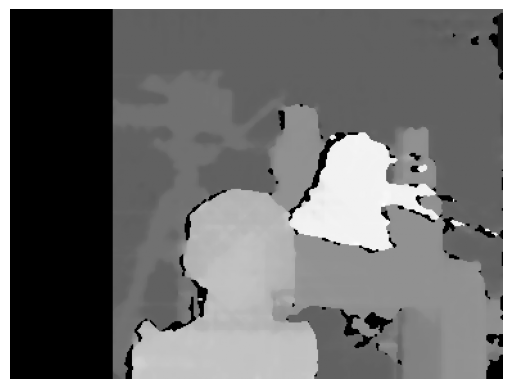

In [39]:
result1 = ShowDisparity(bSize=5)
plt.imshow(result1, 'gray')
plt.axis('off')
plt.show()

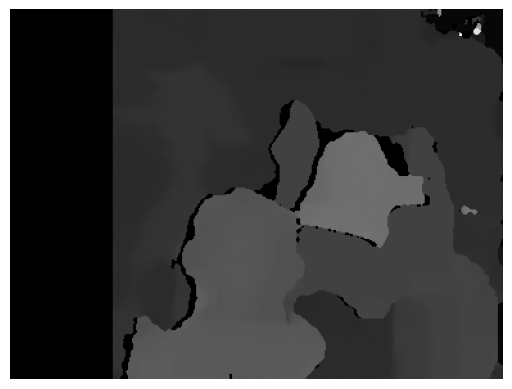

In [40]:
result = ShowDisparity(bSize=25)
plt.imshow(result, 'gray')
plt.axis('off')
plt.show()

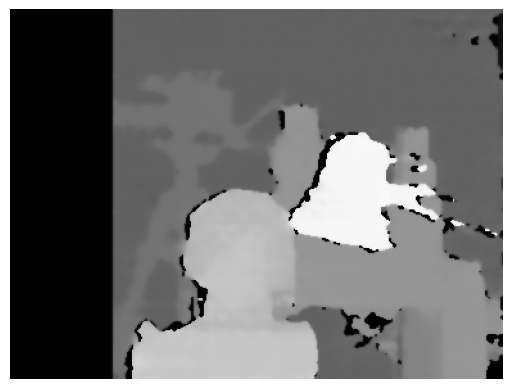

In [42]:
result1_filtered = cv2.bilateralFilter(result1.astype(np.uint8), 5, 75, 75)
plt.imshow(result1_filtered, 'gray')
plt.axis('off')
plt.show()

In [43]:
f = 20 
B = 10  
pixel_size = 0.1  

height, width = result1_filtered.shape

points = []
colors = []

min_depth = 5  
max_depth = 100  
min_disparity = 1 

for y in range(height):
    for x in range(width):
        d = result1_filtered[y, x] * pixel_size  
        if d > 0 and d < max_depth and d > min_disparity:  
            Z = (f * B) / d  
            if Z >= min_depth and Z <= max_depth:  
                X = (x - width / 2) * Z / f  
                Y = (y - height / 2) * Z / f  
                color = imgLeft[y, x] / 255.0  
                points.append([X, Y, Z])
                colors.append(color)

points = np.array(points)
colors = np.array(colors)
depth_colormap = cv2.applyColorMap(np.uint8(result1_filtered), cv2.COLORMAP_JET)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=1.0)
o3d.visualization.draw_geometries([cl])

In [44]:
ply_filename = "output.ply"
o3d.io.write_point_cloud(ply_filename, cl)

True